In [2]:
"""
This notebook load scores that are computed in :
- experiments/mc_repeated_training.py
and plots ROC curves for all models.
"""

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Project paths
LOGS_FOLDER = Path("/Users/dtrizna/Code/QuasarNix/experiments/logs_mc_repeated_training_1763474762")
ROOT = LOGS_FOLDER.parents[1]

import sys
sys.path.append(str(ROOT))

# Load ground-truth labels for the fixed test split (same for all MC runs)
from src.data_utils import load_data

summary_path = LOGS_FOLDER / "mc_models_summary.csv"
summary_df = pd.read_csv(summary_path)

base_seed = int(summary_df["seed"].min())
X_train_cmds, y_train, X_test_cmds, y_test, *_ = load_data(
    root=ROOT,
    seed=base_seed,
    limit=None,
    baseline="real",
)
y_test = np.asarray(y_test)


def get_scores_path(run_idx: int, seed: int, model_name: str) -> Path:
    """Location for cached prediction scores for a given (run, seed, model).

    Scores are stored as NumPy arrays of probabilities so we can recompute
    metrics and ROC curves without re-running inference.
    """
    filename = f"scores_{model_name}_mc_run_{run_idx}_seed_{seed}.npy"
    return LOGS_FOLDER / filename


def load_scores_for_model(model_name: str):
    """Load cached scores for all Monte Carlo runs of a given model.

    Returns
    -------
    runs_df : pandas.DataFrame
        Subset of summary_df for this model.
    scores : np.ndarray
        Array of shape (num_runs, num_examples) with per-run scores.
    """
    runs_df = summary_df[summary_df["model_name"] == model_name].copy()
    runs_df.sort_values(["run_idx", "seed"], inplace=True)

    all_scores: list[np.ndarray] = []
    for _, row in runs_df.iterrows():
        run_idx = int(row["run_idx"])
        seed = int(row["seed"])
        scores_path = get_scores_path(run_idx, seed, model_name)
        scores = np.load(scores_path)
        assert scores.shape[0] == y_test.shape[0], "Scores and labels length mismatch"
        all_scores.append(scores)

    scores = np.stack(all_scores, axis=0)
    return runs_df, scores



Loaded scores for model 'cnn' from 10 runs, 470128 test examples each.


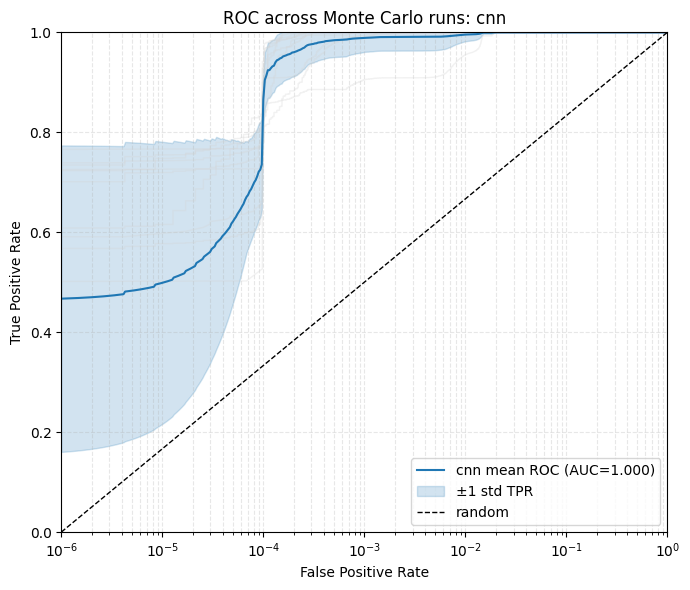

In [3]:
# Configure which model's ROC curve to plot
MODEL_NAME = "cnn"  # change to any model_name present in summary_df

def plot_roc_curve(model_name: str, ax=None):
    runs_df, scores_runs = load_scores_for_model(model_name)
    num_runs, num_examples = scores_runs.shape
    print(f"Loaded scores for model '{model_name}' from {num_runs} runs, {num_examples} test examples each.")

    # Compute ROC curve per run and aggregate mean ROC
    fpr_grid = np.logspace(-6, 0, 400)
    tprs_interpolated: list[np.ndarray] = []
    aucs: list[float] = []

    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 6))
        created_ax = True

    for run_idx, scores in zip(runs_df["run_idx"], scores_runs):
        fpr, tpr, _ = roc_curve(y_test, scores)
        auc_val = roc_auc_score(y_test, scores)
        aucs.append(auc_val)
        # interpolate TPR on a common FPR grid for averaging
        tprs_interpolated.append(np.interp(fpr_grid, fpr, tpr))
        # light grey per-run curves
        ax.plot(fpr, tpr, color="lightgrey", alpha=0.3, linewidth=1)

    mean_tpr = np.mean(tprs_interpolated, axis=0)
    std_tpr = np.std(tprs_interpolated, axis=0)
    mean_auc = float(np.mean(aucs))

    ax.plot(fpr_grid, mean_tpr, color="C0", label=f"{MODEL_NAME} mean ROC (AUC={mean_auc:.3f})")
    ax.fill_between(fpr_grid, mean_tpr - std_tpr, mean_tpr + std_tpr, color="C0", alpha=0.2, label="±1 std TPR")

    ax.plot([1e-6, 1.0], [1e-6, 1.0], "k--", linewidth=1, label="random")
    ax.set_xscale("log")
    ax.set_xlim([1e-6, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC across Monte Carlo runs: {MODEL_NAME}")
    ax.grid(True, which="both", linestyle="--", alpha=0.3)
    ax.legend(loc="lower right")
    if created_ax:
        fig.tight_layout()
        plt.show()

    return ax

_ = plot_roc_curve(MODEL_NAME)

Using 10 Monte Carlo runs per model in this plot.


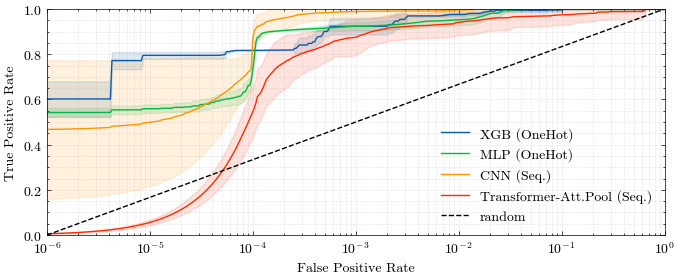

In [11]:
# Plot ROC curves for all models together
import matplotlib.pyplot as plt
import scienceplots
from sigma.collection import SigmaCollection
from experiments.signatures_sigma import rule_matches_command
from tqdm import tqdm

plt.style.use(["science", "no-latex"])

# Optionally provide nicer display names for legend
# Keys here must match `model_name` values in `mc_models_summary.csv`
pretty_model_names = {
    # "_tabular_rf_onehot": "Tabular RF (OneHot)",
    "_tabular_xgb_onehot": "XGB (OneHot)",
    "_tabular_mlp_onehot": "MLP (OneHot)",
    "cnn": "CNN (Seq.)",
    "attpool_transformer": "Transformer-Att.Pool (Seq.)",
    # "neurlux": "CNN+LSTM+Attention",
    # "cnn_lstm": "CNN+LSTM",
    # "mlp_seq": "MLP-Seq",
    # "cls_transformer": "CLS-Transformer",
    # "mean_transformer": "Mean-Transformer",
    # "lstm": "LSTM",
    # "oc_svm_sgd_baseline": "OneClassSVM(benign)",
    # "oc_svm_sgd_malicious": "OneClassSVM (malicious)",
}
run_sigma = False

COLORS = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C10"]
n_mc_runs = int(summary_df["run_idx"].nunique())
print(f"Using {n_mc_runs} Monte Carlo runs per model in this plot.")

plt.figure(figsize=(7, 3))
ax = plt.gca()
fpr_grid = np.logspace(-6, 0, 400)

# To ensure legend always displays all models, store handles/labels
handles = []
labels = []

for i, model_name in enumerate(pretty_model_names.keys()):
    try:
        runs_df, scores_runs = load_scores_for_model(model_name)
    except Exception as e:
        print(f"Skipping {model_name}: {e}")
        continue
    num_runs, num_examples = scores_runs.shape
    tprs_interpolated = []
    aucs = []
    for scores in scores_runs:
        fpr, tpr, _ = roc_curve(y_test, scores)
        auc_val = roc_auc_score(y_test, scores)
        aucs.append(auc_val)
        tprs_interpolated.append(np.interp(fpr_grid, fpr, tpr))
    mean_tpr = np.mean(tprs_interpolated, axis=0)
    std_tpr = np.std(tprs_interpolated, axis=0)
    mean_auc = float(np.mean(aucs))
    # Get pretty name for legend, fallback to code name
    legend_name = pretty_model_names.get(model_name, model_name)
    plot_line, = ax.plot(
        fpr_grid, mean_tpr, color=COLORS[i % len(COLORS)],
        label=f"{legend_name}"# (AUC={mean_auc:.3f})"
    )
    ax.fill_between(
        fpr_grid, mean_tpr - std_tpr, mean_tpr + std_tpr,
        color=COLORS[i % len(COLORS)], alpha=0.13
    )
    handles.append(plot_line)
    labels.append(f"{legend_name}")# (AUC={mean_auc:.3f})")

# --- Sigma ruleset ROC on a 10k subset of X_test_cmds ---
try:
    if not run_sigma:
        raise Exception("Sigma ruleset evaluation disabled")

    sigma_rule_folder = ROOT / "data" / "signatures"
    sigma_rule_yamls = [
        str(p)
        for p in sigma_rule_folder.iterdir()
        if p.suffix in (".yaml", ".yml")
    ]
    sigma_rule_collection = SigmaCollection.load_ruleset(sigma_rule_yamls)

    subset_size = 10_000
    n_test = len(y_test)
    subset_size = min(subset_size, n_test)

    rng = np.random.default_rng(int(base_seed))
    subset_idx = rng.choice(n_test, size=subset_size, replace=False)

    X_sigma = [X_test_cmds[i] for i in subset_idx]
    y_sigma = y_test[subset_idx]

    y_sigma_pred = np.zeros_like(y_sigma, dtype=int)
    for i, cmd in tqdm(enumerate(X_sigma), total=len(X_sigma), desc="Evaluating Sigma ruleset"):
        matched = False
        for rule in sigma_rule_collection:
            if rule_matches_command(rule, cmd):
                matched = True
                break
        y_sigma_pred[i] = 1 if matched else 0

    y_sigma_prob = y_sigma_pred.astype(float)
    fpr_sigma, tpr_sigma, _ = roc_curve(y_sigma, y_sigma_prob)
    auc_sigma = roc_auc_score(y_sigma, y_sigma_prob)

    # Avoid FPR=0 for log-scale plotting
    mask = fpr_sigma >= 1e-6
    fpr_sigma_plot = fpr_sigma[mask]
    tpr_sigma_plot = tpr_sigma[mask]

    sigma_label = f"Sigma ruleset (n={len(y_sigma)}, AUC={auc_sigma:.3f})"
    sigma_line, = ax.plot(
        fpr_sigma_plot,
        tpr_sigma_plot,
        color="C8",
        linestyle="-.",
        linewidth=2,
        label=sigma_label,
    )
    handles.append(sigma_line)
    labels.append(sigma_label)

    print(f"Sigma ruleset ROC on subset of {len(y_sigma)} test samples: AUC={auc_sigma:.4f}")
except Exception as e:
    pass

random_line, = ax.plot([1e-6, 1.0], [1e-6, 1.0], "k--", linewidth=1, label="random")
handles.append(random_line)
labels.append("random")

ax.set_xscale("log")
ax.set_xlim([1e-6, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
# ax.set_title(f"ROC ({n_mc_runs} runs/model)")
ax.grid(True, which="both", linestyle="--", alpha=0.3)
# Explicitly pass collected handles and labels to legend to ensure all models appear
ax.legend(handles, labels, loc="lower right")
plt.savefig("../img/roc_mc_repeated_training.pdf", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()

